In [1]:
import tensorflow as tf
import tflite_runtime.interpreter as tflite
print(tf.__version__)
import IPython
print(IPython.__version__)
import IPython.display as display


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools
print ("Done")

2021-07-30 18:15:29.609581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-30 18:15:29.609647: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0-dev20210730
7.25.0
Done


In [2]:
# content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
# style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

content = tf.keras.utils.load_img('img/kevin_avant.jpg')
style = tf.keras.utils.load_img('style/graf1.jpg')

style_predict_path = tf.lite.Interpreter('models/prediction.tflite')
style_transform_path = tf.lite.Interpreter('models/transfer.tflite')
# style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
# style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

In [3]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

In [4]:
# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

In [5]:
# Load the input images.
content_image = load_img('img/kevin_avant.jpg')
style_image = load_img('style/graf1.jpg')

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

2021-07-30 18:17:58.327337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-30 18:17:58.327387: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-30 18:17:58.327409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-JGN33OD): /proc/driver/nvidia/version does not exist
2021-07-30 18:17:58.336610: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


In [34]:
hello = tf.constant('Hello, TensorFlow!')
print(hello)

tf.Tensor(b'Hello, TensorFlow!', shape=(), dtype=string)


In [35]:
tf.test.is_gpu_available()

False

In [36]:
tf.config.list_physical_devices('GPU')

[]

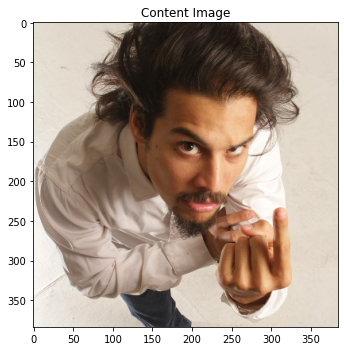

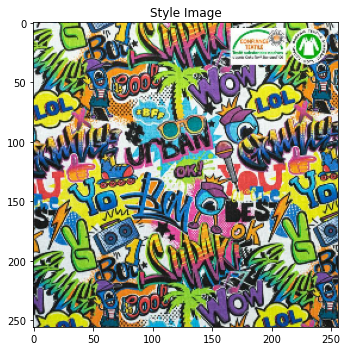

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
  plt.show()

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

In [7]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path='models/prediction.tflite')

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck


In [8]:
# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


In [9]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path='models/transfer.tflite')

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

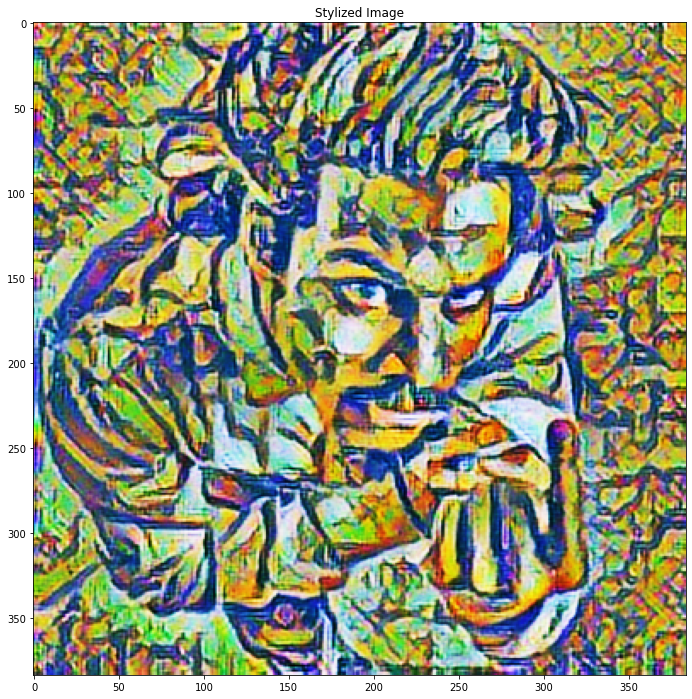

In [10]:
# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')